In [64]:
# Define IAM role
import os
import boto3
import time
import re
from sagemaker import get_execution_role

import pandas as pd
import numpy as np

role = get_execution_role()
bucket = 'pilho-data'
prefix = 'awsdevday'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://pilho-data/awsdevday/train
Validation set location s3://pilho-data/awsdevday/val
Trained model will be saved at s3://pilho-data/awsdevday/output


In [2]:
s3 = boto3.resource('s3')
sourceBucket = s3.Bucket('pilho-data')

In [3]:
role_array = role.split('/')
role_name = role_array[len(role_array) - 1]
print(role_name)

AmazonSageMaker-ExecutionRole-20180917T155747


In [135]:
'''
The original code comes from https://github.com/quentinf00/API-S3-Lambda/blob/bb5d279396195acfa113f4f074587d714e4ed504/athena.py

It is modified and enhanced by Pil Ho Kim for this demonstration, 16th October 2018
'''
import os
import boto3
from time import sleep
import uuid
import csv
from io import StringIO

# This is the new bucket that stores the query results
# RESULT_BUCKET = 'aws-athena-query-results-082256166551-us-east-1'
RESULT_BUCKET = 'pilho-sagemaker-ai-workshop-kr' # This bucket should be in the same region with the source data bucket
DB = 'default' # This folder should exists before querying
ADD_HEADER_TO_RESULT = False

athena = boto3.client('athena')

# This is the function that start the execution and get the results
def get_results(query, database=DB):
    query_id = hash(query)

    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': f's3://{RESULT_BUCKET}/athena/{query_id}'
        }
    )

    results = get_query_results(response['QueryExecutionId'])
    return results

# This is the function that start the execution and get the results
def get_results_for_pd(query, database=DB):
    query_id = hash(query)

    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': f's3://{RESULT_BUCKET}/athena/{query_id}'
        }
    )

    results = get_query_results_for_pd(response['QueryExecutionId'])
    return results

# This query does not return the result set but the address of newly created S3 bucket with a key name
# Mostly used for a query result too big to display and for the use of ML training
def get_results_in_s3(query, database=DB):
    query_id = hash(query)
    s3_output_location = f's3://{RESULT_BUCKET}/athena/{query_id}'
    
    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': s3_output_location
        }
    )
    
    run_result = get_query_results_in_s3(response['QueryExecutionId'])
    #display(run_result)
    s3_output_location = run_result['response']['QueryExecution']['ResultConfiguration']['OutputLocation']
    
    #remove_1st_line_in_s3(s3_output_location)
    reformat_csv(s3_output_location)
    
    return s3_output_location

#This function polls the state of the query execution each second and fetches the results once it's finished
def get_query_results(exec_id):
    run_status = False
    
    while(not run_status):
        current_status = is_execution_done(exec_id)
        run_status = current_status['status']
        print('not done yet')
        sleep(1)

    results = athena.get_query_results(
        QueryExecutionId=exec_id,
    )
    #print(results)

    return format_result(results)

#This function polls the state of the query execution each second and fetches the results once it's finished
def get_query_results_for_pd(exec_id):
    run_status = False
    
    while(not run_status):
        current_status = is_execution_done(exec_id)
        run_status = current_status['status']
        print('not done yet')
        sleep(1)

    results = athena.get_query_results(
        QueryExecutionId=exec_id,
    )
    #print(results)

    return format_result_for_pd(results)

#This function polls the state of the query execution each second and fetches the results once it's finished
def get_query_results_in_s3(exec_id):
    run_status = False
    
    while(not run_status):
        current_status = is_execution_done(exec_id)
        run_status = current_status['status']
        print('not done yet')
        sleep(1)

    athena.get_query_results(
        QueryExecutionId=exec_id,
    )

    return current_status

# This function checks the state of the execution, returns true if it is SUCCEEDED
def is_execution_done(exec_id):
    response = athena.get_query_execution(
        QueryExecutionId=exec_id,
    )
    
    if response['QueryExecution']['Status']['State'] == 'FAILED':
        display(response)
        raise Exception('Failed Athena query')

    # display(response)
    
    return {
        'response': response,
        'status': response['QueryExecution']['Status']['State'] == 'SUCCEEDED'
    }
        

# This functions just parses the rows and return a list of dictionnaries
def format_result(results):
    if ADD_HEADER_TO_RESULT == False:
        return results

    columns = [
        col['Label']
        for col in results['ResultSet']['ResultSetMetadata']['ColumnInfo']
    ]

    formatted_results = []

    for result in results['ResultSet']['Rows'][1:]:
        values = [list(field.values())[0] for field in result['Data']]

        formatted_results.append(
            dict(zip(columns, values))
        )

    return formatted_results

# This functions just parses the rows and return a list of dictionnaries
def format_result_for_pd(results):
    if ADD_HEADER_TO_RESULT == False:
        return results

    columns = [
        col['Label']
        for col in results['ResultSet']['ResultSetMetadata']['ColumnInfo']
    ]

    formatted_results = []

    for result in results['ResultSet']['Rows'][1:]:
        values = [list(field.values())[0] for field in result['Data']]

        formatted_results.append(
            dict(zip(columns, values))
        )

    return formatted_results
def split_s3_path(s3_path):
    path_parts=s3_path.replace("s3://","").split("/")
    bucket=path_parts.pop(0)
    key="/".join(path_parts)
    return bucket, key

# This utility function removes the first line of a file stored in S3 bucket
# Note that this method has a limit to the max file size that fits into /tmp directory (which is 30GB in this configuration)
def remove_1st_line_in_s3(s3_bucket_url):
    unique_filename = str(uuid.uuid4())
    source_bucket, source_key = split_s3_path(s3_bucket_url)
    
    boto3.resource('s3').Bucket(source_bucket).download_file(source_key, '/tmp/'+unique_filename)
    
    with open('/tmp/'+unique_filename, 'r+') as f: #open in read / write mode
        f.readline() #read the first line and throw it out
        data = f.read() #read the rest
        f.seek(0) #set the cursor to the top of the file
        f.write(data) #write the data back
        f.truncate() #set the file size to the current size

    boto3.client('s3').upload_file('/tmp/'+unique_filename, source_bucket, source_key)
    
def reformat_csv(s3_bucket_url):
    data = pd.read_csv(s3_bucket_url)
    source_bucket, source_key = split_s3_path(s3_bucket_url)

    csv_buffer = StringIO()
    data.to_csv(csv_buffer, header=False, index=False, quoting=csv.QUOTE_ALL)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(source_bucket, source_key).put(Body=csv_buffer.getvalue())

In [24]:
query_results = get_results(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS game_trajectory(
    posnewy int, 
    posnewx int, 
    pidx int
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' 
STORED AS TEXTFILE
LOCATION 's3://pilho-data/awsdevday/'
TBLPROPERTIES (
    'skip.header.line.count'='1'
)
""")
print(query_results)

not done yet
not done yet
not done yet
[]


In [25]:
query_results = get_results(f"""
    MSCK REPAIR TABLE game_trajectory
""")
print(query_results)

not done yet
not done yet
not done yet
not done yet
[]


In [26]:
query_results = get_results(f"""
    SHOW TABLES IN default
""")
print(query_results)

not done yet
not done yet
[]


In [27]:
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
import numpy as np

In [28]:
query_results = get_results(f"""
    SELECT COUNT(*) FROM game_trajectory
""")
display(query_results)

not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet


[{'_col0': '166000'}]

In [136]:
entire_position_set = get_results_in_s3(f"""
    SELECT 
        posnewy,
        posnewx
    FROM game_trajectory
""")
display(entire_position_set)

not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet


's3://pilho-sagemaker-ai-workshop-kr/athena/-4760153261164779588/c645d507-ef38-41ef-b138-af2d801e693a.csv'

In [138]:
data = pd.read_csv(entire_position_set, header=None,names=('posnewy','posnewx'))
display(data)

,posnewy,posnewx
0,638,762
1,635,764
2,636,764
3,636,766
4,637,766
5,640,767
6,637,765
7,635,763
8,633,762
9,633,763


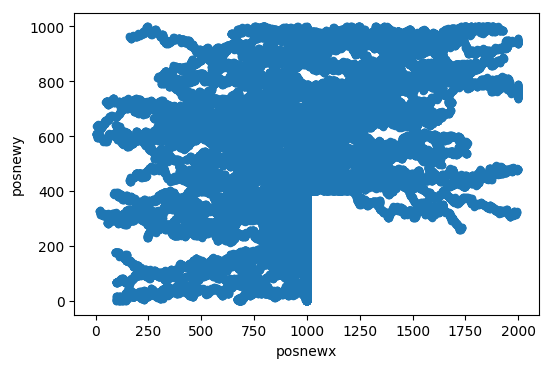

In [139]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.dpi'] = 100

data.plot.scatter(
    x='posnewx',
    y='posnewy'
)

In [140]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'randomcutforest')

entire_position_set = 's3://pilho-sagemaker-ai-workshop-kr/athena/-4760153261164779588/test3.csv'
s3_train_input = sagemaker.s3_input(
    s3_data=entire_position_set,
    content_type='text/csv;label_size=0',
    distribution='ShardedByS3Key'
)

session = sagemaker.Session()

rcf = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    output_path='s3://pilho-sagemaker-ai-workshop-kr/sagemaker/game',
    train_instance_count=1,
    train_instance_type='ml.c5.xlarge',
    sagemaker_session=session
)

rcf.set_hyperparameters(
    num_samples_per_tree=512,
    num_trees=50,
    feature_dim=2
)

# run the training job on input data stored in S3
rcf.fit({'train': s3_train_input})

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-10-16-12-49-47-766


2018-10-16 12:49:47 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-10-16 12:51:21 Downloading - Downloading input data
2018-10-16 12:51:29 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[10/16/2018 12:52:00 INFO 140245969090368] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[10/16/2018 12:52:00 INFO 140245969090368] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'2', u'num_samples_per_tree': u'512', u'num_trees': u'50'}
[1


2018-10-16 12:52:04 Uploading - Uploading generated training model
2018-10-16 12:52:09 Completed - Training job completed
Billable seconds: 49


In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.deserializer = json_deserializer

In [66]:
results = rcf_inference.predict(data.as_matrix().reshape(-1,2))
scores = [datum['score'] for datum in results['scores']]

In [ ]:
data['score'] = pd.Series(scores, index=data.index)

score_mean = data.score.mean()
score_std = data.score.std()

score_cutoff = score_mean + 3*score_std
anomalies = data[data['score'] > score_cutoff]

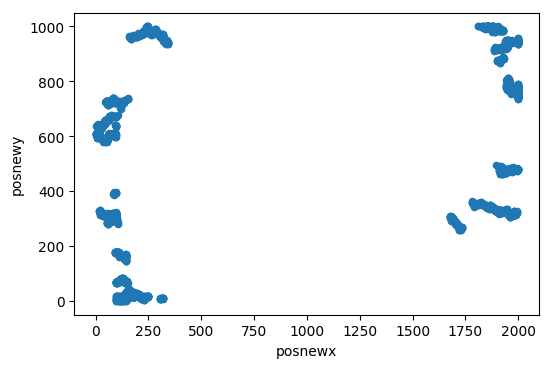

In [67]:
import matplotlib.pyplot as plt


anomalies.plot.scatter(
    x='posnewx',
    y='posnewy'
)